In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from datetime import datetime as dt

import tensorflow as tf
from tensorflow import keras

from module import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

2023-01-16 23:08:30.071509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Data
- 해당의 데이터는 movielens 데이터이며, train_test_split 으로 나누어져 훈련용, 시험용 데이터로 나누어진다.
- generate_trainset, generate_testset 으로 인해 반환되는 값은 numpy array의 형식으로 X, y 로 반환된다.

In [3]:
loader = DataLoader()

X_train, y_train = loader.generate_trainset()
X_test, y_test = loader.generate_testset()

print("훈련 데이터 shape : {}, 훈련 라벨 갯수 : {}".format(X_train.shape, y_train.size))
print("테스트 데이터 shape : {}, 테스트 라벨 갯수 : {}".format(X_test.shape, y_test.size))

훈련 데이터 shape : (80003, 2), 훈련 라벨 갯수 : 80003
테스트 데이터 shape : (19259, 2), 테스트 라벨 갯수 : 19259


# 2. Neural Collaborative Filtering (Neural CF)

## 1. Generate Neural CF Model Process

In [13]:
# 1. Setting Value

# Global
num_users = loader.num_users
num_items = loader.num_items
regs = 0

# GMF Setting
latent_features = 8

# MLP Setting
layers = list(map(int, [64,32,16,8]))
num_layers = len(layers)

In [14]:
# 2. 입력 층 생성
user_input = keras.Input(shape=(1,), dtype='int32')
item_input = keras.Input(shape=(1,), dtype='int32')

In [15]:
# 3-1. GMF Layer Group 생성 (embedding -> flatten -> multiply)
user_model_gmf = keras.Sequential()
item_model_gmf = keras.Sequential()

user_model_gmf.add(user_input)
item_model_gmf.add(item_input)

# 3-1-1. embedding
user_embedding_gmf = keras.layers.Embedding(
                    num_users,
                    latent_features,
                    embeddings_regularizer=keras.regularizers.l2(regs),
                    name='user_emebedding')
item_embedding_gmf = keras.layers.Embedding(
                    num_items,
                    latent_features,
                    embeddings_regularizer=keras.regularizers.l2(regs),
                    name='item_emebedding')
user_model_gmf.add(user_embedding_gmf)
item_model_gmf.add(item_embedding_gmf)


# 3-1-2. flatten
user_latent_gmf = keras.layers.Flatten()
item_latent_gmf = keras.layers.Flatten()
user_model_gmf.add(user_latent_gmf)
item_model_gmf.add(item_latent_gmf)

# 3-1-3. multiply
user_output_gmf = user_model_gmf(X_train[:, 0])
item_output_gmf = item_model_gmf(X_train[:, 1])
concat = keras.layers.Multiply()
gmf_result = concat([user_output_gmf, item_output_gmf])

print("---- 사용자 X 아이템 ----")
print("입력 값: {} {}".format(X_train[0, 0], X_train[0, 1]))
print("GMF 출력 값: {}".format(gmf_result[0].numpy()))
print("훈련 데이터 shape: {}\n".format(gmf_result.shape))

---- 사용자 X 아이템 ----
입력 값: 0 0
GMF 출력 값: [ 0.00132061 -0.00094719  0.00154065 -0.00035883 -0.00054394  0.00052732
 -0.00064469  0.00016438]
훈련 데이터 shape: (80003, 8)



In [16]:
# 3-2. MLP Layer Group 생성 (embedding -> flatten -> concatenate -> hidden layers)
user_model_mlp = keras.Sequential()
item_model_mlp = keras.Sequential()

user_model_mlp.add(user_input)
item_model_mlp.add(item_input)

# 3-2-1. embedding
user_embedding_mlp = keras.layers.Embedding(
                    num_users,
                    int(layers[0] / 2),
                    embeddings_regularizer=keras.regularizers.l2(regs),
                    name='user_emebedding')
item_embedding_mlp = keras.layers.Embedding(
                    num_items,
                    int(layers[0] / 2),
                    embeddings_regularizer=keras.regularizers.l2(regs),
                    name='item_emebedding')
user_model_mlp.add(user_embedding_mlp)
item_model_mlp.add(item_embedding_mlp)

# 3-2-2. flatten
user_latent_mlp = keras.layers.Flatten()
item_latent_mlp = keras.layers.Flatten()
user_model_mlp.add(user_latent_mlp)
item_model_mlp.add(item_latent_mlp)

# 3-2-3. concatenate
user_output_mlp = user_model_mlp(X_train[:, 0])
item_output_mlp = item_model_mlp(X_train[:, 1])
vector = keras.layers.Concatenate()
concatenates_output = vector([user_output_mlp, item_output_mlp])

# 3-2-4. hidden layers
hidden_model = keras.Sequential()
for index in range(num_layers):
    hidden_layer = keras.layers.Dense(
                    layers[index],
                    kernel_regularizer=keras.regularizers.l2(regs),
                    activation = keras.activations.relu,
                    name = "layer_{}".format(index)
                   )
    hidden_model.add(hidden_layer)
mlp_result = hidden_model(concatenates_output)

print("---- 사용자 X 아이템 ----")
print("입력 값: {}".format(X_train[0, 0], X_train[0, 1]))
print("MLP 출력 값: {}".format(mlp_result[0].numpy()))
print("훈련 데이터 shape: {}\n".format(mlp_result.shape))

---- 사용자 X 아이템 ----
입력 값: 0
MLP 출력 값: [0.         0.         0.02590442 0.01074686 0.03258268 0.
 0.02817096 0.03529551]
훈련 데이터 shape: (80003, 8)



In [21]:
# 4. concat GMF output and MLP output
concat_neural = keras.layers.Concatenate()
concat_neural = concat_neural([gmf_result, mlp_result])

print("---- GMF X MLP ----")
print("입력 값: {} {}".format(X_train[0, 0], X_train[0, 1]))
print("GMF X MLP 출력 값: {}".format(concat_neural[0].numpy()))
print("훈련 데이터 shape: {}\n".format(concat_neural.shape))

---- GMF X MLP ----
입력 값: 0 0
GMF X MLP 출력 값: [ 0.00132061 -0.00094719  0.00154065 -0.00035883 -0.00054394  0.00052732
 -0.00064469  0.00016438  0.          0.          0.02590442  0.01074686
  0.03258268  0.          0.02817096  0.03529551]
훈련 데이터 shape: (80003, 16)



In [25]:
# 5. Dense Layer
output = keras.layers.Dense(1, kernel_initializer=keras.initializers.lecun_uniform(),name='output')
result = output(concat_neural)

print("---- Neural CF 는 GMF가 학습하는 선형적 관계와 MLP가 학습하는 비선형적 관계를 이용하여 학습한다. ----")
print("---- Neural CF ----")
print("입력 값: {} {} / 정답 값: {}".format(X_train[0, 0], X_train[0, 1], y_train[0]))
print("Neural CF 출력 값: {}".format(result[0].numpy()))
print("훈련 데이터 shape: {}\n".format(result.shape))

---- Neural CF 는 GMF가 학습하는 선형적 관계와 MLP가 학습하는 비선형적 관계를 이용하여 학습한다. ----
---- Neural CF ----
입력 값: 0 0 / 정답 값: 4.5
Neural CF 출력 값: [0.02524006]
훈련 데이터 shape: (80003, 1)



## 2. Use

In [26]:
# 1. model setting
from model import NeuralMF
model = NeuralMF(loader.num_users, loader.num_items).get_model()

In [27]:
# 2. Callbacks
early_stop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# model_out_file = 'Pretrain/GMF_%s.h5' % (datetime.now().strftime('%Y-%m-%d-%h-%m-%s'))
# model_check_cb = keras.callbacks.ModelCheckpoint(model_out_file, save_best_only=True)

In [28]:
# 3. Compile
learner = "adam"
learning_rate = 0.001

if learner == "adagrad":
    model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=learning_rate), loss='mse')
elif learner == "rmsprop":
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate), loss='mse')
elif learner == "adam":
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
else:
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate), loss='mse')

In [29]:
# 4. Train
epochs = 20
batch_size = 256

history = model.fit(
            [X_train[:, 0], X_train[:, 1]], y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([X_test[:, 0], X_test[:, 1]], y_test),
            callbacks=[early_stop_cb]
        )

Epoch 1/20
313/313 [==============================] - 3s 6ms/step - loss: 3.0852 - val_loss: 0.8125
Epoch 2/20
313/313 [==============================] - 2s 6ms/step - loss: 0.7680 - val_loss: 0.7947
Epoch 3/20
313/313 [==============================] - 2s 7ms/step - loss: 0.7244 - val_loss: 0.7951
Epoch 4/20
313/313 [==============================] - 2s 8ms/step - loss: 0.6622 - val_loss: 0.7919
Epoch 5/20
313/313 [==============================] - 3s 9ms/step - loss: 0.5752 - val_loss: 0.8019
Epoch 6/20
313/313 [==============================] - 3s 11ms/step - loss: 0.5040 - val_loss: 0.8264
Epoch 7/20
313/313 [==============================] - 3s 10ms/step - loss: 0.4595 - val_loss: 0.8479
Epoch 8/20
313/313 [==============================] - 3s 9ms/step - loss: 0.4270 - val_loss: 0.8783
Epoch 9/20
313/313 [==============================] - 3s 8ms/step - loss: 0.4042 - val_loss: 0.8898
Epoch 10/20
313/313 [==============================] - 3s 9ms/step - loss: 0.3849 - val_loss: 0.91

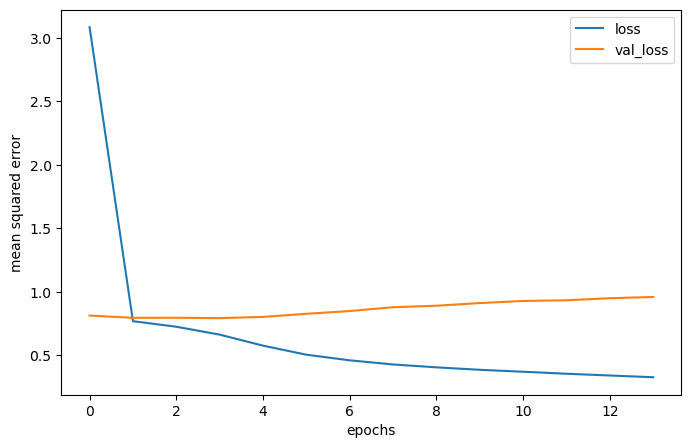

1/1 [==============================] - 0s 22ms/step
[4.2299156 3.4171631 3.652168  3.2907884 4.238387  3.5569942 3.9587076
 3.5760942 3.678002  1.9445953]
[5. 3. 4. 4. 5. 5. 5. 3. 4. 2.]


In [32]:
# 5. Result
pd.DataFrame(history.history).plot(figsize= (8,5))
plt.xlabel("epochs")
plt.ylabel("mean squared error")
plt.show()
test_sample = X_test[:10]
test_sample_label = y_test[:10]
print(model.predict([test_sample[:, 0], test_sample[:, 1]]).flatten())
print(test_sample_label)

In [33]:
history.history

{'loss': [3.085163116455078,
  0.7680258750915527,
  0.7243986129760742,
  0.6622155904769897,
  0.5752027034759521,
  0.5039938688278198,
  0.4594922363758087,
  0.42704999446868896,
  0.40419501066207886,
  0.38494783639907837,
  0.36961865425109863,
  0.35378098487854004,
  0.3399602770805359,
  0.32639041543006897],
 'val_loss': [0.8125192523002625,
  0.794663667678833,
  0.7951484322547913,
  0.7919329404830933,
  0.8018991351127625,
  0.8264184594154358,
  0.8479171991348267,
  0.8782544732093811,
  0.8898159265518188,
  0.9108707904815674,
  0.9275127649307251,
  0.9330037236213684,
  0.9490031599998474,
  0.958888053894043]}